# Generative Adversarial Network
In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

<img src='assets/gan_pipeline.png' width=70% />

## step 1.0
Import all the packages required 

In [21]:

%matplotlib inline 

import torch
import numpy as np
import matplotlib.pyplot as plt




### convert the  data to tensors
### create training data

In [24]:
from torchvision import datasets
import torchvision.transforms as transforms

num_workers  = 0

batch_size   = 64

#convert the data to torch.FloatTensor
transform    = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root = 'data',
                            train= True,
                            download= True,
                            transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           num_workers= num_workers)



### Visualize the data

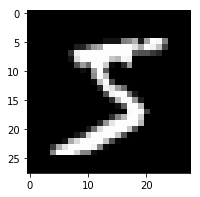

In [26]:
dataiter = iter(train_loader)
images, labels =dataiter.next()
images = images.numpy()


img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax  = fig.add_subplot(111)
ax.imshow(img , cmap = 'gray')


# The Model

## Discriminator :
<img src='assets/gan_network.png' width=70% />


In [29]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    
    
    def __init__(self, input_size, hidden_dim ,output_size):
        super(Discriminator , self).__init__()
        
        ##All the layers
        self.fc1 = nn.Linear(input_size,hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # fully connected layers 
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layers 
        self.dropout= nn.Dropout(0.3)
        
        
    def forward(self, x):
        x = x.view(-1 , 28*28)
        x = F.leaky_relu(self.fc1(x) , negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x) , negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x) , negative_slope = 0.2)
        x = self.dropout(x)
        #final layer
        x = self.fc4(x) 
        logits = x
        
        return logits
    
        

### Generator
The generator network will be almost exactly the same as the discriminator network, except that we're applying a tanh activation function to our output layer.

### tanh Output
The generator has been found to perform the best with  𝑡𝑎𝑛ℎ  for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1.



In [30]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator , self).__init__()
        
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        
        self.fc4 = nn.Linear(hidden_dim*4 , output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))
        
        return out
    
    
        

# Hyperparamenters

In [31]:
input_size = 784

disc_output_size = 1

disc_hidden_size = 32

z_size = 100

gen_output_size = 784

gen_hidden_size = 32


## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses:
The losses will by binary cross entropy loss with logits, which we can get with BCEWithLogitsLoss. This combines a sigmoid activation function and and binary cross entropy loss in one function.

In [43]:
## Discriminator and Generator Losses

def real_loss(D_out , smooth = False):
    batch_size = D_out.size(0)
    
    if smooth :
        labels = torch.ones(batch_size)* 0.9
        
    else :
        labels = torch.ones(batch_size)
    
    
    criterion = nn.BCEWithLogitsLoss()
    loss      = criterion(D_out.squeeze() , labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze() , labels)
    return loss

        

### Discriminator Losses

# optimizers

In [44]:
import torch.optim as optim

lr = 0.002

disc_optimizer = optim.Adam(D.parameters() , lr)
gene_optimizer = optim.Adam(G.parameters() , lr)



# Training

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

In [54]:
import pickle as pkl
num_epochs = 2

samples = []

losses  = []

print_every = 400

sample_size = 16

fixed_z = np.random.uniform(-1 ,1 , size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()


## train the network

D.train()
G.train()


for epoch in range(num_epochs):
    
    for batch_i , (real_images , _ ) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1
        #------------------------
        # Discriminator training
        #-------------------------
        disc_optimizer.zero_grad()
        
        d_real = D(real_images)
        d_real_loss = real_loss(d_real , smooth =True)
        
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        d_fake = D(fake_images)
        d_fake_loss = fake_loss(d_fake)
        
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        disc_optimizer.step()
        
        #------------------------
        # generator  training
        #------------------------
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        d_fake = D(fake_images)
        g_loss = real_loss(d_fake)
        
        g_loss.backward()
        gene_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
        
        
        
        losses.append((d_loss.item(), g_loss.item()))
        
        
        # generate and save sample, fake images
        G.eval() # eval mode for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to train mode
        
        
#Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        

Epoch [    1/    2] | d_loss: 0.3279 | g_loss: 47.5070
Epoch [    1/    2] | d_loss: 0.3286 | g_loss: 48.6218
Epoch [    1/    2] | d_loss: 0.3270 | g_loss: 47.4866
Epoch [    2/    2] | d_loss: 0.3275 | g_loss: 48.5092
Epoch [    2/    2] | d_loss: 0.3263 | g_loss: 48.4979
Epoch [    2/    2] | d_loss: 0.3261 | g_loss: 54.9103


# Training loss

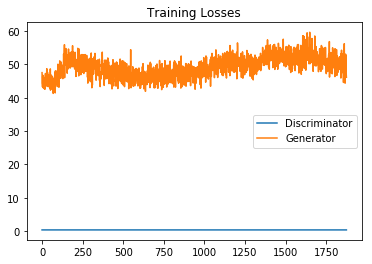

In [58]:
fig , ax = plt.subplots()

losses = np.array(losses)
plt.plot(losses.T[0] , label = 'Discriminator')
plt.plot(losses.T[1] , label = 'Generator')
plt.title("Training Losses")
plt.legend()


# Generator samples from training

In [59]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [60]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

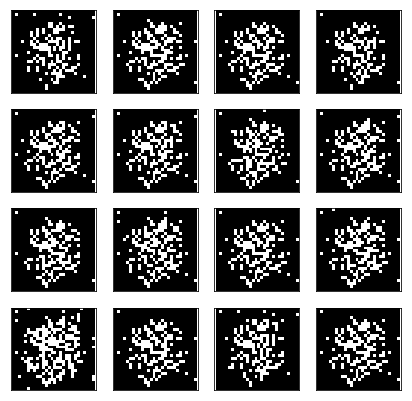

In [51]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

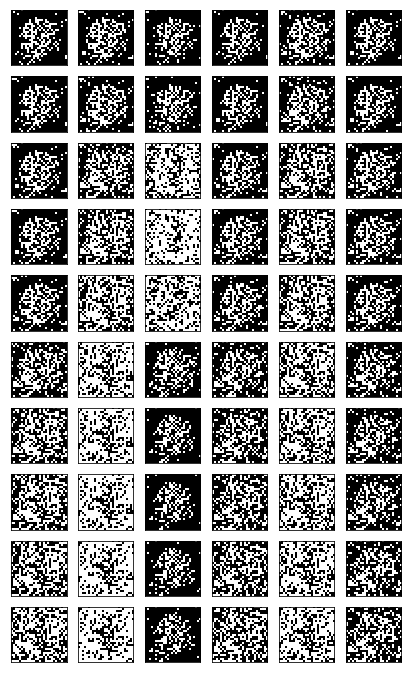

In [61]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Sampling from the generator
We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector  𝑧  and we'll get new samples!

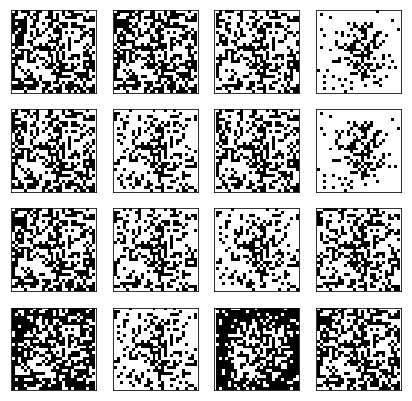

In [62]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])